In [49]:
import os
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import glob
import random
import itertools
import pickle

In [50]:
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score

from sklearn.svm import SVC  # 2
from sklearn.neural_network import MLPClassifier  # 4
from sklearn.ensemble import AdaBoostClassifier  # 6

In [51]:
directory = "/content/drive/MyDrive/Dogs_Dataset/images_cropped"
categories = os.listdir(directory)
categories.sort()
split_data = "/content/drive/MyDrive/Dogs_Dataset/Data"

**1**

In [52]:
# Convert the images to grayscale pixel intensity histograms
def convt_to_gray(image):

    im = cv2.imread(image)
    scale = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    im = np.array(scale)

    hists,bins = np.histogram(im,bins=256,range=(0,256))
    histogram = hists.flatten()

    return histogram

**2**

In [53]:
#  Standardization on the dataset.
def std_data(vect):
    feature = vect.reshape(-1,1)
    scaler = StandardScaler()
    standardized_feature = scaler.fit_transform(feature)
    standardized_feature = standardized_feature.flatten()
    return standardized_feature

**3**

In [54]:
for i in categories:
    data = []
    class_path = os.path.join(directory,i)
    label = categories.index(i)
    for img in os.listdir(class_path):
        img_path = os.path.join(class_path,img)
        vect = convt_to_gray(img_path)
        standardized_vect = std_data(vect)
        data.append([standardized_vect,label])

    # Splitting data of each class for training and testing in 80:20 ratio.
    train_data,test_data = train_test_split(data,train_size=0.8, test_size=0.2, random_state=2)

    destination_path = os.path.join(split_data,i)
    if not os.path.exists(destination_path):
        os.makedirs(destination_path)

    train_split = open(os.path.join(destination_path,'train.pickle'),'wb')
    pickle.dump(train_data,train_split)
    train_split.close()

    test_split = open(os.path.join(destination_path,'test.pickle'),'wb')
    pickle.dump(test_data,test_split)
    test_split.close()

    print(f"Class : {i}")
    print(f"Label : {label}")
    print(f"Number of training samples : {len(train_data)}")
    print(f"Number of testing samples : {len(test_data)}")
    print("--"*10)

Class : n02093647-Bedlington_terrier
Label : 0
Number of training samples : 145
Number of testing samples : 37
--------------------
Class : n02099849-Chesapeake_Bay_retriever
Label : 1
Number of training samples : 133
Number of testing samples : 34
--------------------
Class : n02100735-English_setter
Label : 2
Number of training samples : 128
Number of testing samples : 33
--------------------
Class : n02116738-African_hunting_dog
Label : 3
Number of training samples : 135
Number of testing samples : 34
--------------------


In [55]:
def load_data(load_file):
    load = []
    for i in os.listdir(split_data):
        path = os.path.join(split_data,i,load_file)
        file = open(path,'rb')
        data = pickle.load(file)
        load.extend(data)
        file.close()
    return load

In [56]:
data_train = load_data('train.pickle')
data_test = load_data('test.pickle')
random.shuffle(data_train)
random.shuffle(data_test)

In [57]:
xtrain = []
ytrain = []
for i in data_train:
    xtrain.append(i[0])
    ytrain.append(i[1])
xtrain = np.array(xtrain)
ytrain = np.array(ytrain)

In [58]:
xtest = []
ytest = []
for j in data_test:
    xtest.append(j[0])
    ytest.append(j[1])

**4**

In [59]:
def cross_validation(cv_type,model,xtrain,ytrain):

    train_error = []
    val_error = []

    for train_index, val_index in cv_type.split(xtrain, ytrain):
        X_train, X_val = xtrain[train_index], xtrain[val_index]
        y_train, y_val = ytrain[train_index], ytrain[val_index]

        model.fit(X_train, y_train)

        train_score = model.score(X_train, y_train)
        train_error.append(1 - train_score)

        val_score = model.score(X_val, y_val)
        val_error.append(1 - val_score)

    return(np.mean(train_error),np.mean(val_error))

In [60]:
k_values = [1, 3, 5, 7, 10, 20]

**Standard 5-Fold Cross-validation**

In [61]:
cv_type = KFold(n_splits=5)
standard_train_error = []
standard_validation_error = []

for i in k_values:
    model = KNeighborsClassifier(n_neighbors=i)
    train_error,val_error = cross_validation(cv_type,model,xtrain,ytrain)
    standard_train_error.append(train_error)
    standard_validation_error.append(val_error)
    print(f"n_neighbours : {i}")
    print(f"Mean train error : {train_error}")
    print(f"Mean validation error : {val_error}")
    print("---"*10)

n_neighbours : 1
Mean train error : 0.0
Mean validation error : 0.6525144410465511
------------------------------
n_neighbours : 3
Mean train error : 0.3743082285518775
Mean validation error : 0.6080699966021067
------------------------------
n_neighbours : 5
Mean train error : 0.43807309041142756
Mean validation error : 0.6173462453278967
------------------------------
n_neighbours : 7
Mean train error : 0.47504811393379526
Mean validation error : 0.6173292558613659
------------------------------
n_neighbours : 10
Mean train error : 0.48983512958686165
Mean validation error : 0.6227998640842677
------------------------------
n_neighbours : 20
Mean train error : 0.5240345137285092
Mean validation error : 0.6228168535507985
------------------------------


**Stratified 5-Fold Cross-validation**

In [62]:
cv_type = StratifiedKFold(n_splits=5)
stratified_train_error = []
stratified_validation_error = []

for i in k_values:
    model = KNeighborsClassifier(n_neighbors=i)
    train_error,val_error = cross_validation(cv_type,model,xtrain,ytrain)
    stratified_train_error.append(train_error)
    stratified_validation_error.append(val_error)
    print(f"n_neighbours : {i}")
    print(f"Mean train error : {train_error}")
    print(f"Mean validation error : {val_error}")
    print("---"*10)

n_neighbours : 1
Mean train error : 0.0
Mean validation error : 0.6487767584097859
------------------------------
n_neighbours : 3
Mean train error : 0.3761525960140279
Mean validation error : 0.6154774040095141
------------------------------
n_neighbours : 5
Mean train error : 0.43991959627063554
Mean validation error : 0.6191980971797485
------------------------------
n_neighbours : 7
Mean train error : 0.46858160123171677
Mean validation error : 0.6173122663948352
------------------------------
n_neighbours : 10
Mean train error : 0.49306624754084344
Mean validation error : 0.6098369011213048
------------------------------
n_neighbours : 20
Mean train error : 0.5295751005046617
Mean validation error : 0.6154434250764526
------------------------------


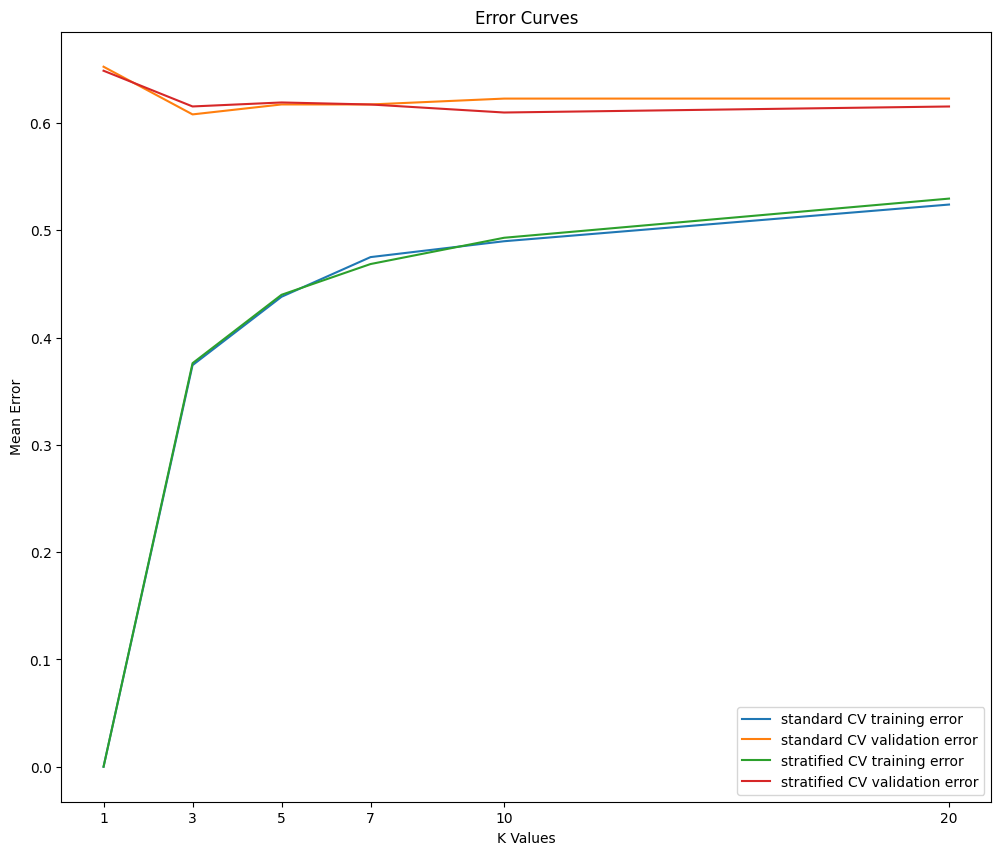

In [63]:
plt.figure(figsize=(12,10))

plt.plot(k_values, standard_train_error, label='standard CV training error')
plt.plot(k_values, standard_validation_error, label='standard CV validation error')
plt.plot(k_values, stratified_train_error, label='stratified CV training error')
plt.plot(k_values, stratified_validation_error, label='stratified CV validation error')

plt.xticks(k_values)

plt.xlabel('K Values')
plt.ylabel('Mean Error')
plt.title("Error Curves")
plt.legend()

plt.show()

The lowest mean error for the curve standard_train_error is at k=1, the lowest mean error for the curve standard_validation_error is at k=3, the lowest mean error for the curve stratified_train_error is at k=1, the lowest mean error for the curve stratified_validation_error is at k=10.

When k is low the complexity of model is high and when k is high complexity of model is low.

At k=1 we can observe overfitting as train error is low and validation error is high. At k=20 we can observe underfitting as model is generalised so train error is high.

In [64]:
model = KNeighborsClassifier(n_neighbors=10)
model.fit(xtrain,ytrain)
preds = model.predict(xtest)
print("Test Error :",1-accuracy_score(preds,ytest))

Test Error : 0.6739130434782609


**5**

In [65]:
classifier_1 = MLPClassifier(hidden_layer_sizes=(10,10,10,))
classifier_2 = SVC(kernel='linear')
classifier_3 = AdaBoostClassifier()

**Confusion Matrices**

In [66]:
def confusion_matx(classifier,xtrain,ytrain):
    cm = []
    stratified_kf = StratifiedKFold(n_splits=5)
    for train_index, val_index in stratified_kf.split(xtrain, ytrain):
        X_train, X_val = xtrain[train_index], xtrain[val_index]
        y_train, y_val = ytrain[train_index], ytrain[val_index]

        classifier.fit(X_train, y_train)
        y_pred = classifier.predict(X_val)

        conf_mat = confusion_matrix(y_val,y_pred)
        cm.append(conf_mat)

    conf_mat = sum(cm)/len(cm)
    cm_display = ConfusionMatrixDisplay(conf_mat, display_labels=categories)
    cm_display.plot()
    plt.xticks(rotation=90)
    plt.title(classifier)
    plt.show()
    print("--"*50)

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptro

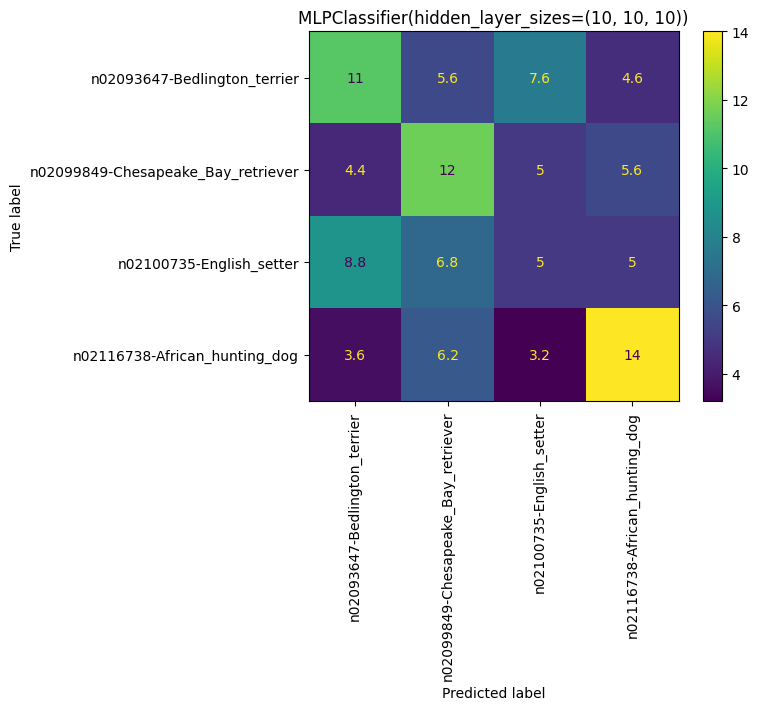

----------------------------------------------------------------------------------------------------


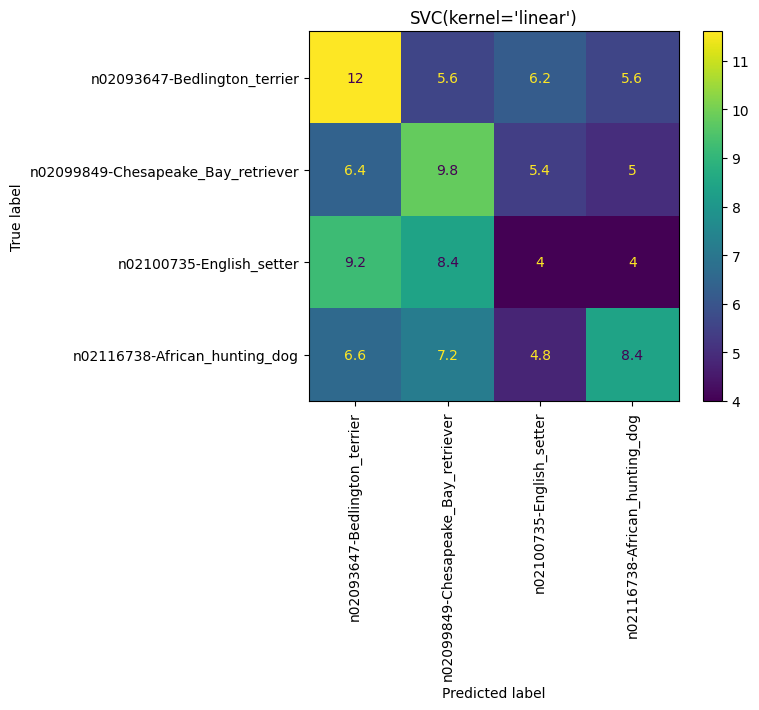

----------------------------------------------------------------------------------------------------


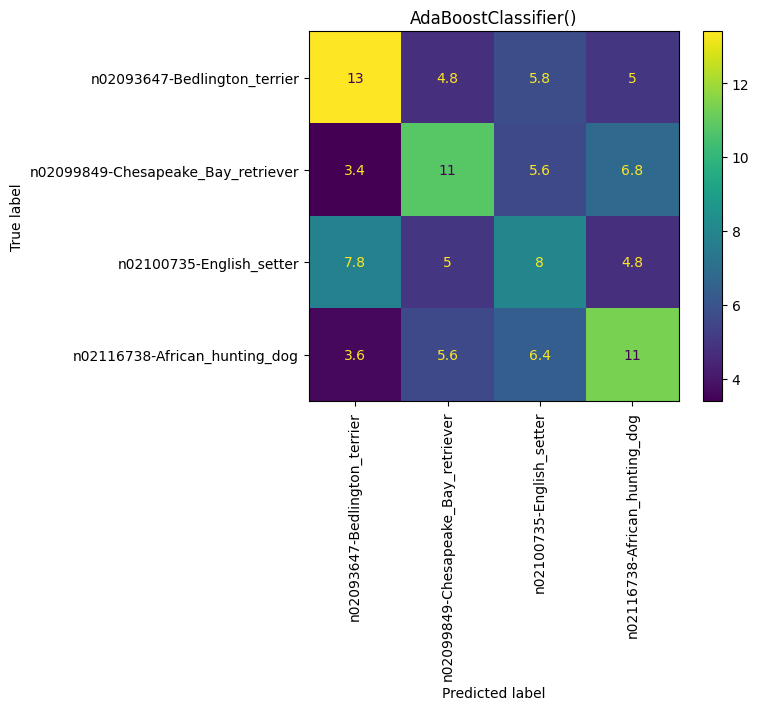

----------------------------------------------------------------------------------------------------


In [67]:
confusion_matx(classifier_1,xtrain,ytrain)
confusion_matx(classifier_2,xtrain,ytrain)
confusion_matx(classifier_3,xtrain,ytrain)

Based on the confusion matrices classifier 3 : AdaBoostClassifier() is the best method since it has more true values.

**Mean Validation Accuracies**

In [68]:
def mean_val_acc(classifier,xtrain,ytrain):
    validation_accuracy = []
    stratified_kf = StratifiedKFold(n_splits=5)
    for train_index, val_index in stratified_kf.split(xtrain, ytrain):
        X_train, X_val = xtrain[train_index], xtrain[val_index]
        y_train, y_val = ytrain[train_index], ytrain[val_index]

        classifier.fit(X_train, y_train)
        y_pred = classifier.predict(X_val)

        validation_accuracy.append(accuracy_score(y_val,y_pred))
    print(f"Mean validation accuracy of {classifier}: {np.mean(validation_accuracy)}")
    print("--"*50)

In [69]:
mean_val_acc(classifier_1,xtrain,ytrain)
mean_val_acc(classifier_2,xtrain,ytrain)
mean_val_acc(classifier_3,xtrain,ytrain)

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptro

Mean validation accuracy of MLPClassifier(hidden_layer_sizes=(10, 10, 10)): 0.3604655113829425
----------------------------------------------------------------------------------------------------
Mean validation accuracy of SVC(kernel='linear'): 0.3123683316343867
----------------------------------------------------------------------------------------------------
Mean validation accuracy of AdaBoostClassifier(): 0.40300713557594287
----------------------------------------------------------------------------------------------------


Based on mean validation accuracy classifier 3 : AdaBoostClassifier() is the best method.

**Model metrics**

In [70]:
def model_metrics(classifier,xtrain,ytrain,xtest,ytest):
    classifier.fit(xtrain,ytrain)
    prediction = classifier.predict(xtest)
    print(f"Model accuracy of {classifier} : {accuracy_score(ytest,prediction)}")
    print(f"Model F-Measure {classifier} : {f1_score(ytest,prediction,average='weighted')}")
    print(classifier)
    print(classification_report(ytest,prediction))
    print("--"*50)

In [71]:
model_metrics(classifier_1,xtrain,ytrain,xtest,ytest)
model_metrics(classifier_2,xtrain,ytrain,xtest,ytest)
model_metrics(classifier_3,xtrain,ytrain,xtest,ytest)

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Model accuracy of MLPClassifier(hidden_layer_sizes=(10, 10, 10)) : 0.2826086956521739
Model F-Measure MLPClassifier(hidden_layer_sizes=(10, 10, 10)) : 0.284993701025899
MLPClassifier(hidden_layer_sizes=(10, 10, 10))
              precision    recall  f1-score   support

           0       0.33      0.27      0.30        37
           1       0.25      0.24      0.24        34
           2       0.22      0.30      0.25        33
           3       0.37      0.32      0.34        34

    accuracy                           0.28       138
   macro avg       0.29      0.28      0.28       138
weighted avg       0.29      0.28      0.28       138

----------------------------------------------------------------------------------------------------
Model accuracy of SVC(kernel='linear') : 0.2971014492753623
Model F-Measure SVC(kernel='linear') : 0.2890425356665224
SVC(kernel='linear')
              precision    recall  f1-score   support

           0       0.32      0.46      0.38        37


Based on the accuracies on the test set classifier 3 : AdaBoostClassifier() is the best method.

Based on the F-Measure on the test set classifier 3 : AdaBoostClassifier() is the best method.